In [1]:
import sys
import numpy as np
from pathlib import Path
from pyPolCal.csv_tools import write_fits_info_to_csv,read_csv,read_csv_physical_model_all_bins
from pyPolCal.fitting import *
from pyPolCal.utils import *
from pyPolCal.plotting import plot_data_and_model
from pyMuellerMat.physical_models.charis_physical_models import *
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
import pandas as pd
# Plot settings that I like
plt.rcParams.update({
    #"text.usetex": True,
    #"font.family": "serif",
   # "font.serif": ["Palatino"],
    "font.size": 16,
   # "text.latex.preamble": r"\usepackage{amsmath}\usepackage{mathpazo}"
})
from pyPolCal.constants import wavelength_bins
from pyPolCal.on_sky import write_fits_info_to_csv_psf,plot_data_and_model_alt

/home/thomasmc/miniconda3/envs/charisenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


First, I am going to perform aperture photometry and write all data to a csv on HD10166, an unpolarized standard star. The function for this is `write_fits_info_to_csv_psf`. There are lots of different possible arguments to configure this function. I'm configuring it in such a way that it fits a Gaussian to the psf and uses 3 x fwhm as the aperture radius, and then does background subtraction using a background annulus with an outer radius 5 pixels larger than 3 x fwhm. I also cap the fwhm at a radius of 9 pixels. I plot every 25th frame so I check for poor psf fits.

In [ ]:
# HD10166
cubedir = Path('/home/shared/exoserver/CHARIS-cals/Nov-onsky/HD10166/cubes/skysub')
cubedir_2 = Path('/home/shared/exoserver/CHARIS-cals/Nov-onsky/HD10166/cubes/data/raw')
rawdir = Path('/home/shared/exoserver/CHARIS-cals/Nov-onsky/HD10166/raw')

centroid_guesses = ([66,85],[131,117]) # Star is unpol, so should be roughly the same on both sides
annuli_radii = ([25,30],[25,30])
aper_radii = [25,25]
hwporder = [0,45,22.5,67.5]
boxsize = 45
max_fwhm = [9,9]

for bin in range(22):
    fname = f'../datacsvs/onsky_nbs/HD10166/bin{bin}.csv'
    write_fits_info_to_csv_psf(cubedir,rawdir,fname,centroid_guesses=centroid_guesses,
                               box_size=boxsize, aperture_radii=aper_radii, bkgd_annuli_radii=annuli_radii,
                               wavelength_bin=bin) 


In [ ]:
# HD7808
cubedir = Path('/home/shared/exoserver/CHARIS-cals/Nov-onsky/HD7808/cubes/skysub')
cubedir_2 = Path('/home/shared/exoserver/CHARIS-cals/Nov-onsky/HD7808/cubes/data/raw')
rawdir = Path('/home/shared/exoserver/CHARIS-cals/Nov-onsky/HD7808/raw')

centroid_guesses = ([66,85],[131,117]) # Star is unpol, so should be roughly the same on both sides
annuli_radii = ([25,30],[25,30])
aper_radii = [25,25]
hwporder = [0,45,22.5,67.5]
boxsize = 45
max_fwhm = [9,9]

for bin in range(22):
    fname = f'../datacsvs/onsky_nbs/HD7808/bin{bin}.csv'
    write_fits_info_to_csv_psf(cubedir_2,rawdir,fname,centroid_guesses=centroid_guesses,
                               box_size=boxsize, aperture_radii=aper_radii, bkgd_annuli_radii=annuli_radii,
                               wavelength_bin=bin,plot_every_x=50) 


I'm going to repeat this process with another star. This star is at a different altitude, which affects the diattenuation. This will help with fitting the mirror model.

In [ ]:
# HD293396
cubedir = Path('/home/shared/exoserver/CHARIS-cals/Nov-onsky/HD293396/cubes/skysub')
rawdir = Path('/home/shared/exoserver/CHARIS-cals/Nov-onsky/HD293396/raw')

centroid_guesses = ([66,85],[129,117]) # Star is unpol, so should be roughly the same on both sides
annuli_radii = ([10,15],[10,15])
hwporder = [0,45,22.5,67.5]
boxsize = 45
max_fwhm = [9,9]
aper_radii = [25,25]
for bin in range(22):
    fname = f'../datacsvs/onsky_nbs/HD293396/bin{bin}.csv'
    write_fits_info_to_csv_psf(cubedir,rawdir,fname,centroid_guesses=centroid_guesses,
                               box_size=boxsize, aperture_radii=aper_radii,
                               wavelength_bin=bin,
                               plot_every_x=25)


In [10]:
interleaved_values, interleaved_stds, configuration_list = read_csv('../datacsvs/onsky_nbs/HD10166_and_HD293396/bin10.csv',mode='m3')
print(configuration_list)

[{'hwp': {'theta': 0.0}, 'image_rotator': {'theta': 83.03516}, 'altitude_rot': {'pa': -39.04453117}, 'parang_rot': {'pa': 25.050172822641503}}, {'hwp': {'theta': 45.0}, 'image_rotator': {'theta': 83.03281}, 'altitude_rot': {'pa': -39.0283135}, 'parang_rot': {'pa': 25.098405301942893}}, {'hwp': {'theta': 22.5}, 'image_rotator': {'theta': 83.02584}, 'altitude_rot': {'pa': -39.01206183}, 'parang_rot': {'pa': 25.14600474893745}}, {'hwp': {'theta': 67.5}, 'image_rotator': {'theta': 83.01138}, 'altitude_rot': {'pa': -38.99579007}, 'parang_rot': {'pa': 25.193691875989128}}, {'hwp': {'theta': 0.0}, 'image_rotator': {'theta': 83.01117}, 'altitude_rot': {'pa': -38.9793223}, 'parang_rot': {'pa': 25.241090560610527}}, {'hwp': {'theta': 45.0}, 'image_rotator': {'theta': 82.95353}, 'altitude_rot': {'pa': -38.96298755}, 'parang_rot': {'pa': 25.28964886049288}}, {'hwp': {'theta': 22.5}, 'image_rotator': {'theta': 82.98238}, 'altitude_rot': {'pa': -38.94663078}, 'parang_rot': {'pa': 25.337072182718742}

I'm going to combine these into one CSV. This will allow me to perform a fit using both of these as my dataset.

In [ ]:
# combine into one csv

# for bin in range(22):
#     fname1 = f'../datacsvs/onsky_nbs/HD10166/bin{bin}.csv'
#     fname2 = f'../datacsvs/onsky_nbs/HD293396/bin{bin}.csv'
#     df1 = pd.read_csv(fname1)
#     df2 = pd.read_csv(fname2)
#     combined_df = pd.concat([df1,df2],ignore_index=True)
#     combined_fname = f'../datacsvs/onsky_nbs/HD10166_and_HD293396/bin{bin}.csv'
#     combined_df.to_csv(combined_fname,index=False)


[[ 0.74427882  0.73855764 -0.06792079 -0.00222273]
 [ 0.74165569  0.74108243 -0.06863192 -0.00224601]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]


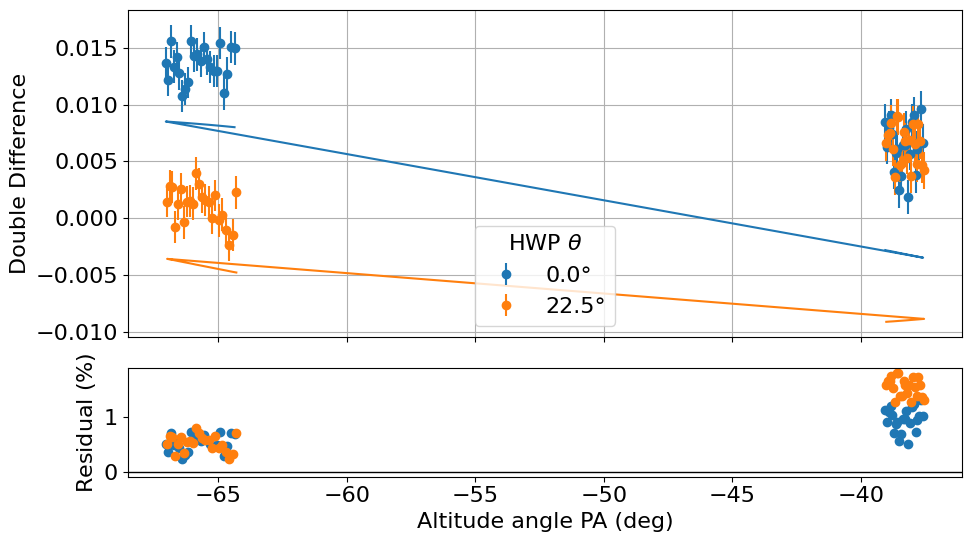

[-0.00281693 -0.00913306 -0.00285227 -0.00912221 -0.00287913 -0.00911024
 -0.00290928 -0.00910134 -0.00293804 -0.0090911  -0.00296891 -0.00908
 -0.0030017  -0.00906872 -0.00303166 -0.00905573 -0.00306634 -0.00904511
 -0.0030952  -0.00903358 -0.00312894 -0.00902127 -0.00315773 -0.0090097
 -0.00318953 -0.00899708 -0.00322374 -0.00898431 -0.00325374 -0.00896995
 -0.00328804 -0.0089579  -0.00331942 -0.00894484 -0.00335264 -0.00893076
 -0.00338526 -0.00891806 -0.00341866 -0.00890386 -0.00345138 -0.00889001
 -0.00348366 -0.00887573  0.0085134  -0.00358802  0.00849739 -0.00362565
  0.00848191 -0.00367281  0.00846513 -0.00372247  0.0084482  -0.00377364
  0.00843042 -0.00382212  0.00841157 -0.00387364  0.00839259 -0.00392443
  0.00837298 -0.00397687  0.00835155 -0.00403095  0.00833038 -0.00409036
  0.00830821 -0.00414262  0.00828622 -0.00419737  0.0082616  -0.00425403
  0.00823757 -0.00431041  0.00821324 -0.00436784  0.00818664 -0.00442676
  0.00816025 -0.00448614  0.00813303 -0.00454683  0.008

np.float64(1.0200018777581425)

In [12]:
from pyMuellerMat.physical_models.charis_physical_models import *
from pyPolCal.constants import wavelength_bins
wavelength_bin = 10
offset_imr = -0.4506# derotator offset
offset_hwp = -1.119# HWP offset
offset_cal = -0.5905 # calibration polarizer offset
imr_theta = 0 # placeholder 
hwp_theta = 0 # placeholder
imr_phi = IMR_retardance(wavelength_bins,259.12694)[wavelength_bin]
hwp_phi = HWP_retardance(wavelength_bins,1.636,1.278)[wavelength_bin]
epsilon_cal = 1
m1, b1, m2, b2 = (1.94073,13.69728,2.07958,13.88817) # from MCMC
m3_diat = M3_diattenuation(wavelength_bins[wavelength_bin],m1,b1,m2,b2)
m3_ret = M3_retardance(wavelength_bins[wavelength_bin],m1,b1,m2,b2)

# Define instrument configuration as system dictionary
# Wollaston beam, imr theta/phi, and hwp theta/phi will all be updated within functions, so don't worry about their values here
system_dict = {
    "components" : {
        "wollaston" : {
        "type" : "CHARIS_wollaston_function",
        "properties" : {"wavelength": wavelength_bins[wavelength_bin], "beam": 'o'}, 
        "tag": "internal",
        },
        "image_rotator" : {
            "type" : "elliptical_IMR_function",
            "properties" : {"wavelength": wavelength_bins[wavelength_bin], "theta": imr_theta, "delta_theta": offset_imr},
            "tag": "internal",
        },
        "hwp" : {
            "type" : "general_retarder_function",
            "properties" : {"phi": hwp_phi, "theta": hwp_theta, "delta_theta": offset_hwp},
            "tag": "internal",
        },
        "diat" : {
            "type" : "diattenuator_retarder_function",
            "properties" : {"epsilon": 0, "delta_theta": 0},
            "tag": "internal",
        },
        "altitude_rot" : {
            "type" : "rotator_function",
            "properties" : {"pa":0},
            "tag":"internal",
        },
        "M3" : {
            "type" : "diattenuator_retarder_function",
            "properties" : {"epsilon":0.5, "theta": 0, "delta_theta":0},
            "tag": "internal",
        },

        "parang_rot" : {
            "type" : "rotator_function",
            "properties" : {"pa":0},
            "tag":"internal",
        },
}
}
system_mm = generate_system_mueller_matrix(system_dict)
print(system_mm.evaluate())

# Get our model retardances from Joost t Hart physical models

p = [m3_diat]


# Define what is in the p list

system_parameters = [['M3','epsilon']]

# Generate our modeled left and right beam intensities

modeled_interleaved = model(p, system_parameters, system_mm, configuration_list)

# Process these into interleaved single norm differences and sums

diffs_sums = process_model(modeled_interleaved)

# Plot the modeled and observed values

fig, ax = plot_data_and_model_alt(interleaved_values, diffs_sums,configuration_list, interleaved_stds=interleaved_stds,wavelength= wavelength_bins[15],include_sums=False,title='')
ax.tick_params(
    axis='x',
    direction='in',
    top=True,
    which='both',  
)
ax.tick_params(
    axis='y',
    direction='in',
    right=True,
    which='both',
)
ax.minorticks_on()
#fig.savefig('/Users/thomasmcintosh/Desktop/CHARIS-REU/overleaf_plots/MCMC_model_single_diff_vs_hwp_1932.png',bbox_inches='tight', dpi=600)
diffs = process_dataset(interleaved_values)[::2]
print(diffs_sums[::2])
pol_acc = np.sqrt(np.sum((diffs*100-diffs_sums[::2]*100)**2)/(len(diffs)-6))
pol_acc

In [ ]:
# for csv in Path('../datacsvs/onsky_nbs/HD7808').glob('*.csv'):
#     df = pd.read_csv(csv)
#     df = df.iloc[:140] # first 140 rows
#     df.to_csv(csv, index=False)

/home/thomasmc/miniconda3/envs/charisenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.3876e+03                                    3.59e+05    
       1              2         2.2059e+03      3.18e+03       1.30e-02       1.40e+05    
       2              3         1.6349e+03      5.71e+02       3.24e-01       1.03e+04    
       3              4         1.5962e+03      3.87e+01       6.87e-01       1.00e+04    
       4              5         1.5179e+03      7.84e+01       1.37e+00       9.92e+03    
       5              6         1.3602e+03      1.58e+02       2.73e+00       1.69e+04    
       6              7         1.0559e+03      3.04e+02       5.42e+00       2.89e+04    
       7              8         6.0101e+02      4.55e+02       1.07e+01       3.57e+04    
       8              9         4.7428e+02      1.27e+02       7.56e+00       6.17e+03    
       9             10         4.7108e+02      3.20e+00       9.96e-01       1.39e+02    

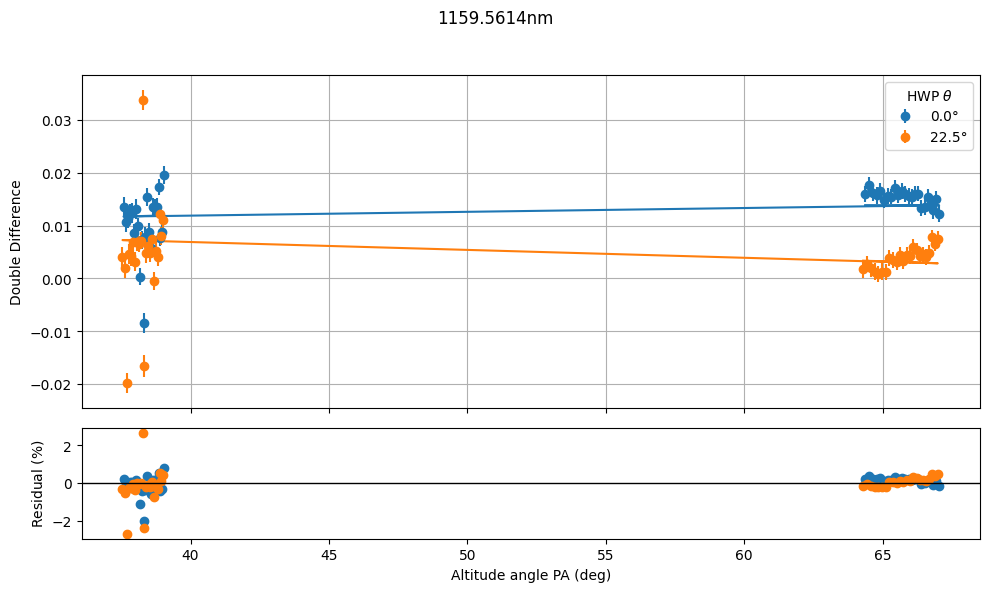

Updated Mueller Matrix:
[[ 0.49823595 -0.01984025  0.49405132  0.06130838]
 [-0.49823595  0.01984025 -0.49405132 -0.06130838]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
360 180
Residuals range: -2.6995944068727598 2.6596336337495914
Error: [5.65488187e-04 1.11493245e+00]
s_res: 0.6012013628137414
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.2294e+03                                    3.71e+05    
       1              2         2.0018e+03      3.23e+03       1.26e-02       1.49e+05    
       2              3         1.3816e+03      6.20e+02       3.14e-01       1.13e+04    
       3              4         1.3404e+03      4.11e+01       6.68e-01       1.10e+04    
       4              5         1.2572e+03      8.33e+01       1.33e+00       1.08e+04    
       5              6         1.0895e+03      1.68e+02       2.66e+00       1.76e+04    
     

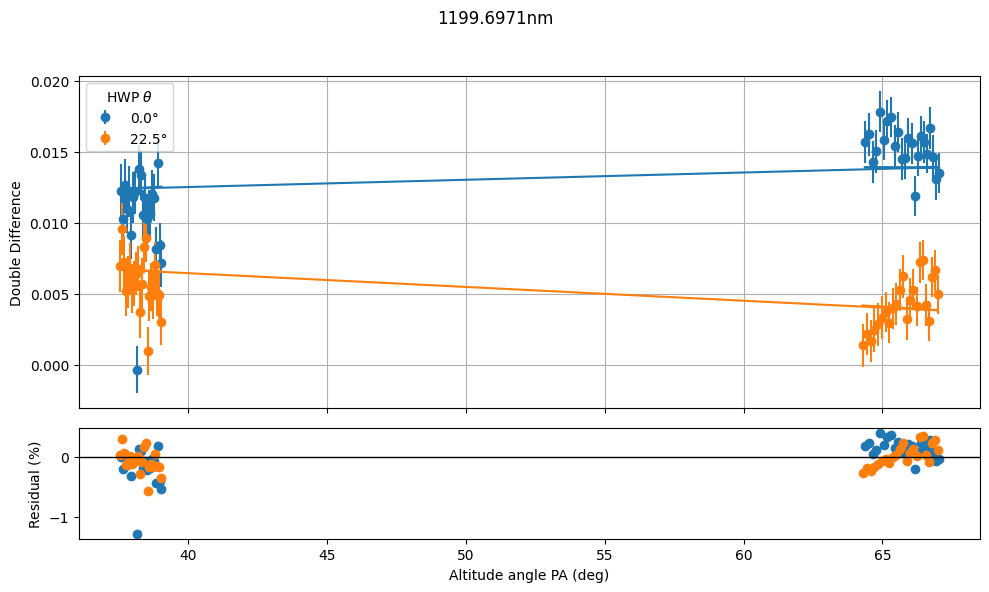

Updated Mueller Matrix:
[[ 0.49782251  0.00852397  0.49187053  0.0430186 ]
 [-0.4938209  -0.00870667 -0.495853   -0.04336413]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
360 180
Residuals range: -1.2799404441812965 0.38860357304424253
Error: [2.58591710e-04 4.98605121e-01]
s_res: 0.2428663462851292
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.8973e+03                                    3.59e+05    
       1              2         1.8810e+03      3.02e+03       1.22e-02       1.41e+05    
       2              3         1.3317e+03      5.49e+02       3.06e-01       1.04e+04    
       3              4         1.2947e+03      3.69e+01       6.50e-01       1.01e+04    
       4              5         1.2197e+03      7.50e+01       1.30e+00       1.01e+04    
       5              6         1.0681e+03      1.52e+02       2.58e+00       1.70e+04    
    

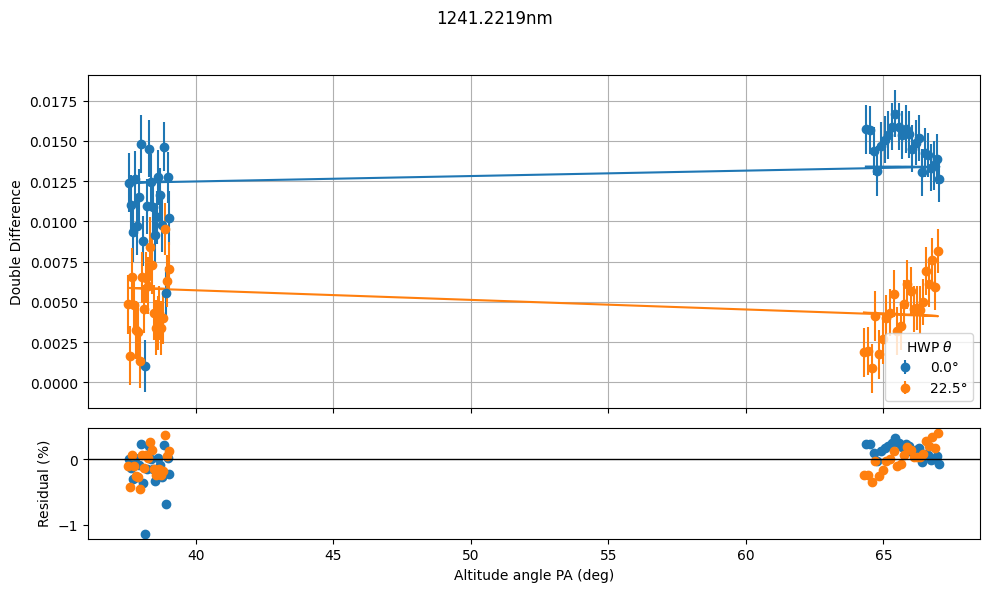

Updated Mueller Matrix:
[[ 0.49775482  0.02856645  0.49402224  0.0234593 ]
 [-0.49540279 -0.02876574 -0.49636321 -0.02356967]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
360 180
Residuals range: -1.1402373582078247 0.40603211846524634
Error: [2.55570539e-04 5.11880246e-01]
s_res: 0.2423201821456971
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.6972e+03                                    3.47e+05    
       1              2         1.8558e+03      2.84e+03       1.19e-02       1.38e+05    
       2              3         1.3272e+03      5.29e+02       2.97e-01       1.02e+04    
       3              4         1.2920e+03      3.52e+01       6.32e-01       9.92e+03    
       4              5         1.2206e+03      7.14e+01       1.26e+00       9.86e+03    
       5              6         1.0758e+03      1.45e+02       2.51e+00       1.65e+04    
    

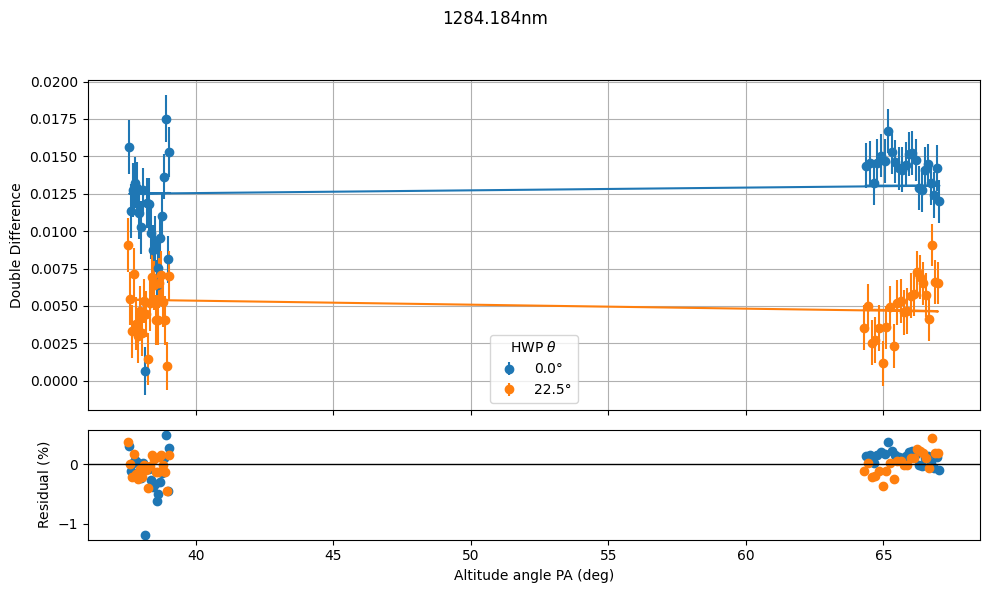

Updated Mueller Matrix:
[[ 0.49757448  0.04794057  0.48597964 -0.00370321]
 [-0.48835091 -0.04909258 -0.49513072  0.00377245]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
360 180
Residuals range: -1.1859262337421475 0.4976089888947637
Error: [2.62540739e-04 5.28894877e-01]
s_res: 0.2478600882198113
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.5560e+03                                    3.37e+05    
       1              2         1.8756e+03      2.68e+03       1.16e-02       1.33e+05    
       2              3         1.3772e+03      4.98e+02       2.89e-01       1.00e+04    
       3              4         1.3435e+03      3.37e+01       6.14e-01       9.77e+03    
       4              5         1.2750e+03      6.85e+01       1.23e+00       9.74e+03    
       5              6         1.1356e+03      1.39e+02       2.44e+00       1.63e+04    
     

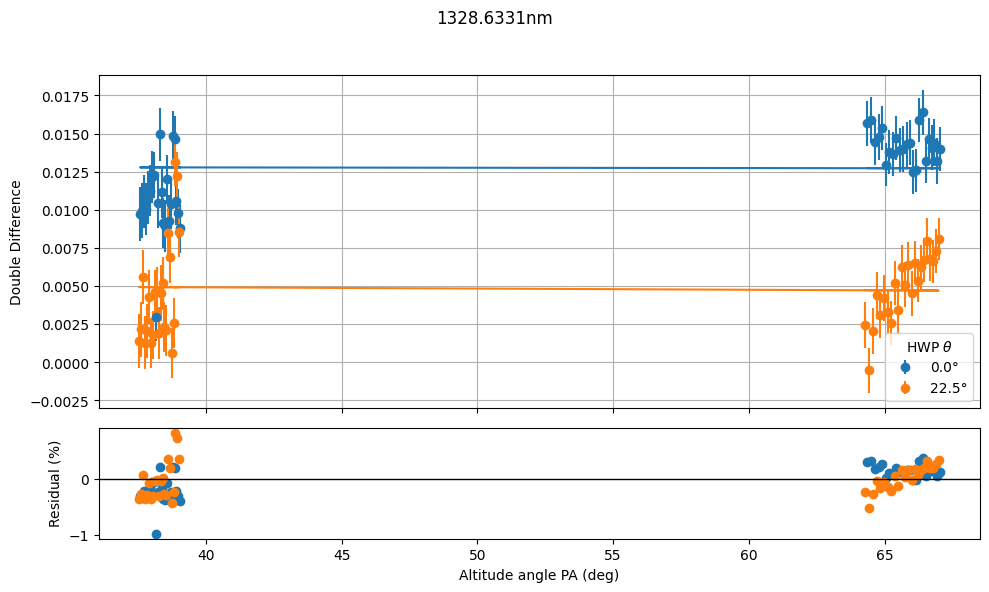

Updated Mueller Matrix:
[[ 0.49769893  0.0514654   0.47187556 -0.08738301]
 [-0.4826473  -0.05347359 -0.48654644  0.09008197]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
360 180
Residuals range: -0.979798718606304 0.8251016781745104
Error: [2.94838873e-04 6.00496273e-01]
s_res: 0.27793189780190064
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.0416e+04                                    2.94e+05    
       1              2         8.1070e+03      2.31e+03       1.12e-02       1.23e+05    
       2              3         7.6191e+03      4.88e+02       2.78e-01       8.55e+03    
       3              4         7.5912e+03      2.80e+01       5.97e-01       8.35e+03    
       4              5         7.5347e+03      5.64e+01       1.19e+00       8.25e+03    
       5              6         7.4215e+03      1.13e+02       2.38e+00       1.27e+04    
     

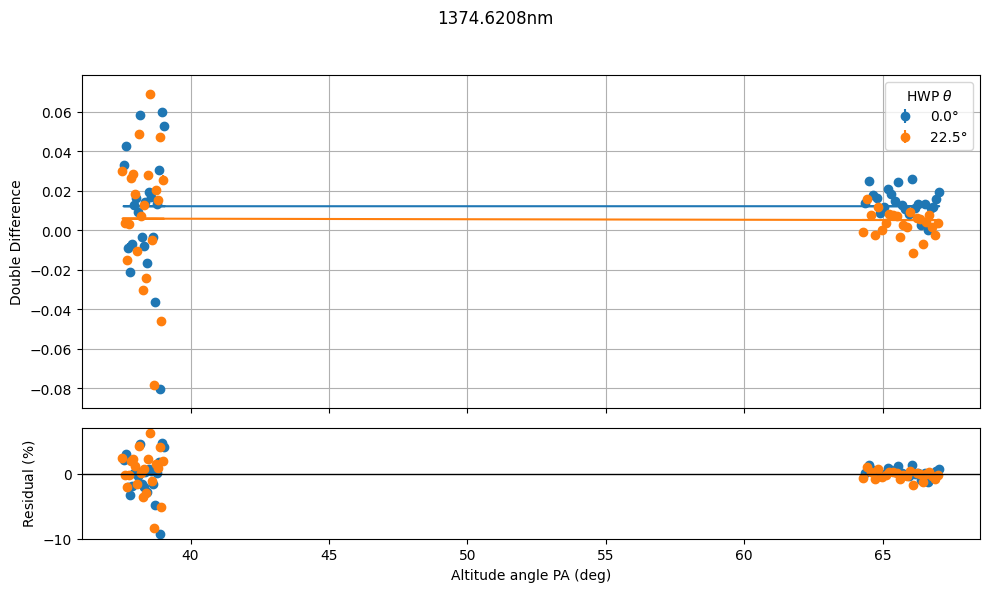

Updated Mueller Matrix:
[[ 0.49746983  0.04409368  0.47665329 -0.11666131]
 [-0.4926984  -0.04464137 -0.48125939  0.11777955]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
360 180
Residuals range: -9.249518422369755 6.320345742682496
Error: [2.22909607e-03 4.68532059e+00]
s_res: 2.328310213073388
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.2146e+03                                    3.13e+05    
       1              2         1.8791e+03      2.34e+03       1.09e-02       1.20e+05    
       2              3         1.4813e+03      3.98e+02       2.75e-01       8.31e+03    
       3              4         1.4549e+03      2.64e+01       5.81e-01       8.10e+03    
       4              5         1.4012e+03      5.37e+01       1.16e+00       8.09e+03    
       5              6         1.2916e+03      1.10e+02       2.31e+00       1.45e+04    
       6

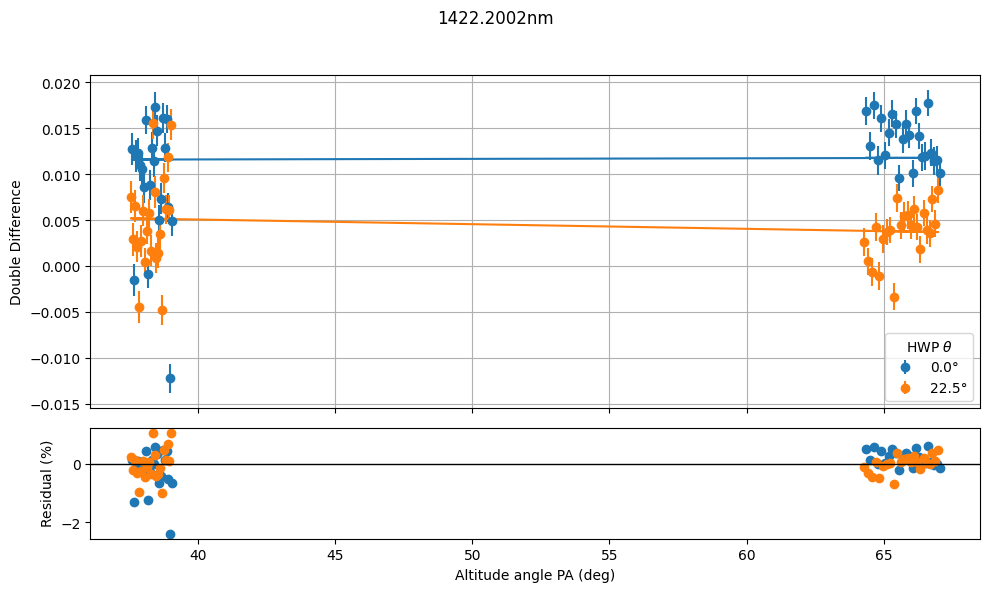

Updated Mueller Matrix:
[[ 0.49820456  0.03588156  0.47354261 -0.1315736 ]
 [-0.49278889 -0.03640897 -0.47873788  0.13300905]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
360 180
Residuals range: -2.3891239841511167 1.0471622364081
Error: [5.16489461e-04 1.16427641e+00]
s_res: 0.4934448900196679
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.9174e+03                                    3.12e+05    
       1              2         1.6644e+03      2.25e+03       1.06e-02       1.18e+05    
       2              3         1.2932e+03      3.71e+02       2.68e-01       8.31e+03    
       3              4         1.2675e+03      2.57e+01       5.64e-01       8.11e+03    
       4              5         1.2151e+03      5.24e+01       1.13e+00       8.13e+03    
       5              6         1.1075e+03      1.08e+02       2.25e+00       1.49e+04    
       6

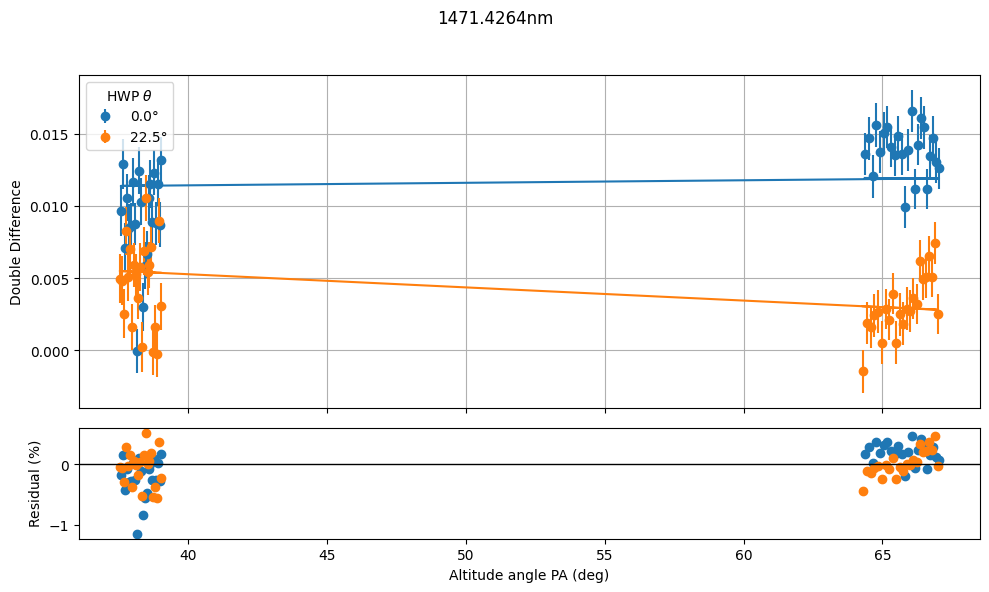

Updated Mueller Matrix:
[[ 0.49861648  0.01861692  0.47160714 -0.14509505]
 [-0.49377293 -0.01892063 -0.47622933  0.14651035]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
360 180
Residuals range: -1.1469443197415568 0.5148371863127403
Error: [3.12551610e-04 7.07910696e-01]
s_res: 0.29578163066234286
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.7399e+03                                    3.09e+05    
       1              2         1.5366e+03      2.20e+03       1.03e-02       1.23e+05    
       2              3         1.1251e+03      4.11e+02       2.58e-01       8.15e+03    
       3              4         1.1006e+03      2.45e+01       5.49e-01       7.96e+03    
       4              5         1.0510e+03      4.97e+01       1.10e+00       7.93e+03    
       5              6         9.5023e+02      1.01e+02       2.19e+00       1.34e+04    
    

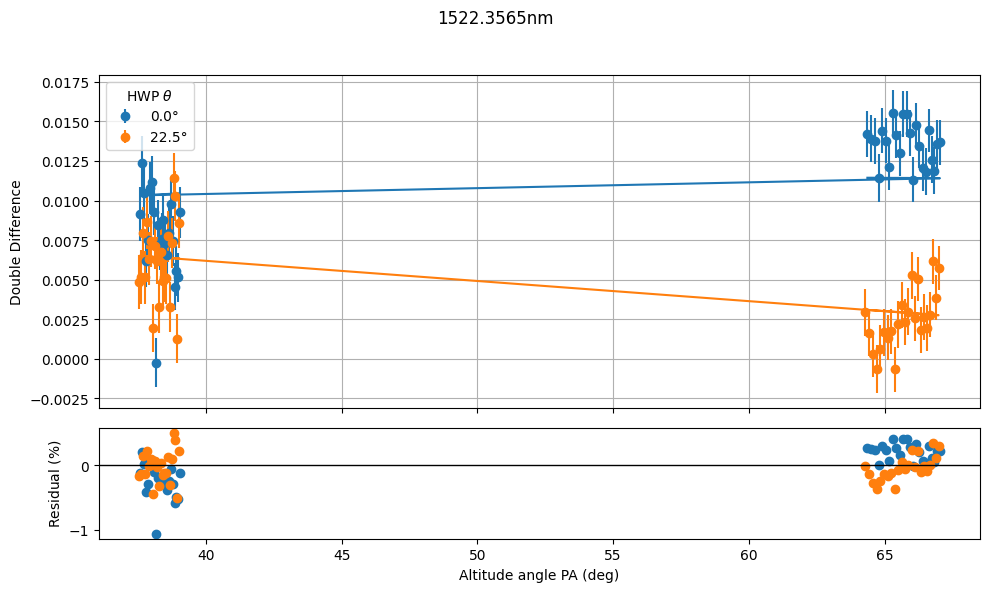

Updated Mueller Matrix:
[[ 0.49859898 -0.00087467  0.46934869 -0.15398319]
 [-0.49396267  0.00077103 -0.47375544  0.15542028]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
360 180
Residuals range: -1.0635398026601344 0.5040950178031852
Error: [2.94727096e-04 6.91256665e-01]
s_res: 0.2728233052691091
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.7990e+03                                    3.05e+05    
       1              2         1.6931e+03      2.11e+03       1.00e-02       1.20e+05    
       2              3         1.3133e+03      3.80e+02       2.52e-01       8.52e+03    
       3              4         1.2885e+03      2.49e+01       5.34e-01       8.32e+03    
       4              5         1.2377e+03      5.08e+01       1.07e+00       8.34e+03    
       5              6         1.1335e+03      1.04e+02       2.12e+00       1.44e+04    
     

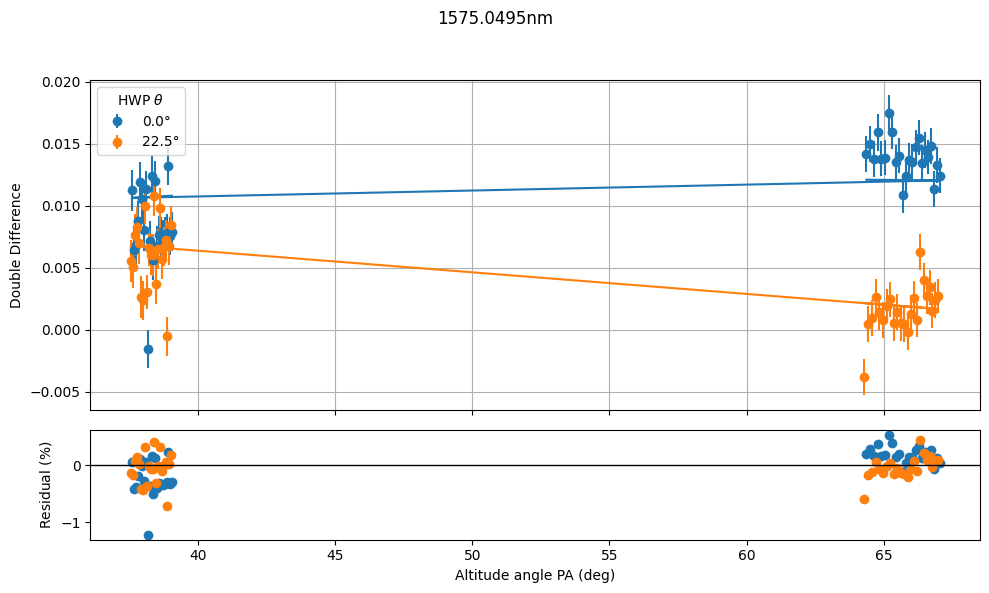

Updated Mueller Matrix:
[[ 0.49908195 -0.01727184  0.4689285  -0.15639334]
 [-0.49462149  0.01731411 -0.47316165  0.15779844]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
360 180
Residuals range: -1.2218598265080156 0.5414649441641293
Error: [3.02855636e-04 6.86227481e-01]
s_res: 0.28341643127326493
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.5277e+03                                    3.04e+05    
       1              2         1.4830e+03      2.04e+03       9.75e-03       1.20e+05    
       2              3         1.1062e+03      3.77e+02       2.45e-01       7.75e+03    
       3              4         1.0842e+03      2.20e+01       5.19e-01       7.58e+03    
       4              5         1.0395e+03      4.47e+01       1.04e+00       7.56e+03    
       5              6         9.4854e+02      9.10e+01       2.07e+00       1.29e+04    
    

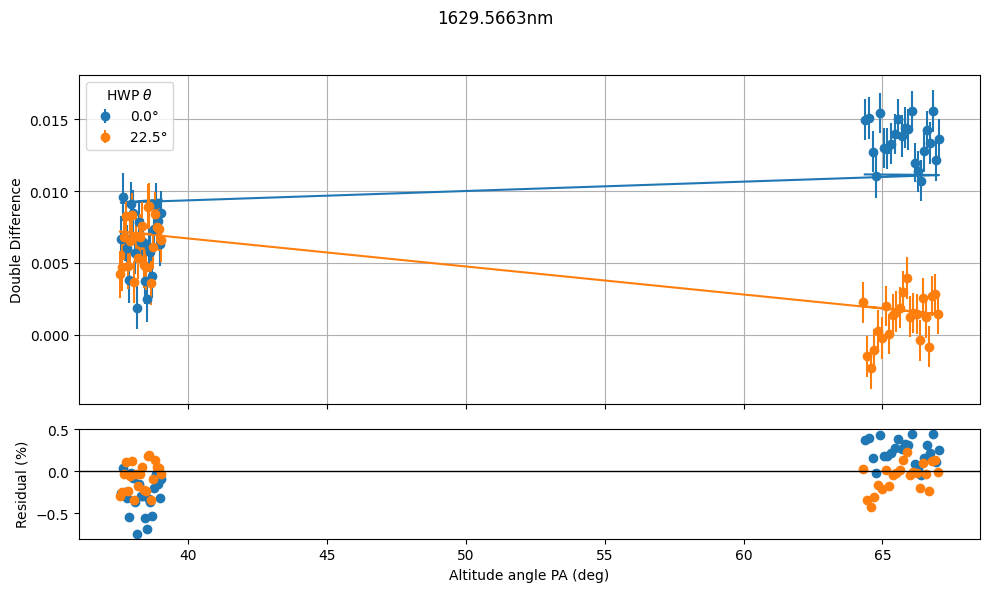

Updated Mueller Matrix:
[[ 0.49914776 -0.0342123   0.46728769 -0.15641957]
 [-0.49395813  0.03444965 -0.47220641  0.15805727]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
360 180
Residuals range: -0.7409002179322558 0.4448586471973668
Error: [2.82648424e-04 6.91469922e-01]
s_res: 0.2623176411141797
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.7412e+03                                    3.18e+05    
       1              2         1.6395e+03      2.10e+03       9.47e-03       1.31e+05    
       2              3         1.2117e+03      4.28e+02       2.36e-01       8.37e+03    
       3              4         1.1885e+03      2.32e+01       5.04e-01       8.20e+03    
       4              5         1.1416e+03      4.69e+01       1.01e+00       8.16e+03    
       5              6         1.0467e+03      9.50e+01       2.01e+00       1.30e+04    
     

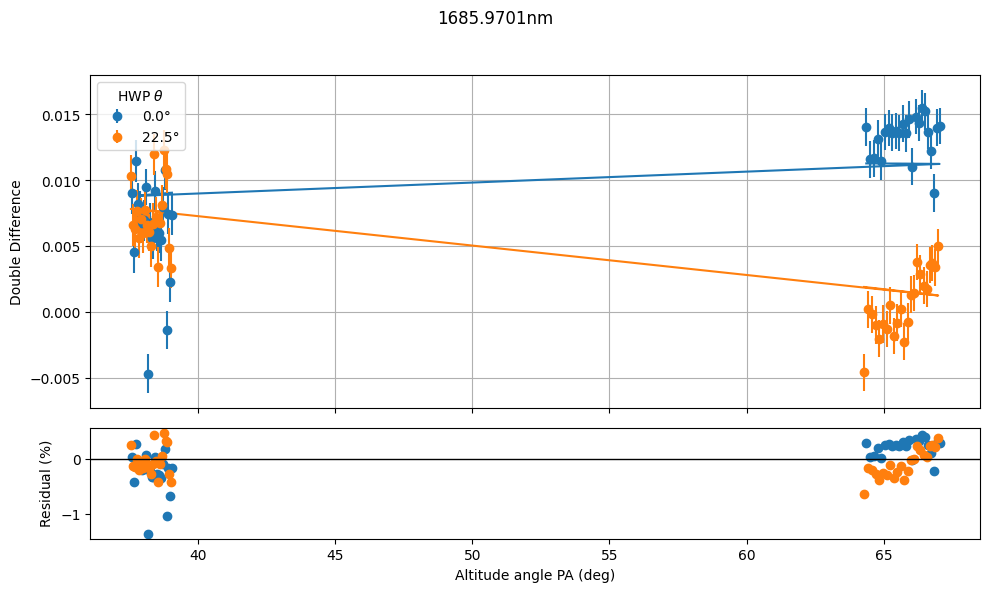

Updated Mueller Matrix:
[[ 0.49919959 -0.04947361  0.46709849 -0.15179174]
 [-0.493628    0.04990016 -0.47238474  0.15349945]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
360 180
Residuals range: -1.3568634712545695 0.46718334775515047
Error: [3.44480130e-04 8.37072876e-01]
s_res: 0.31769109423759
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.4665e+03                                    3.01e+05    
       1              2         1.5580e+03      1.91e+03       9.22e-03       1.18e+05    
       2              3         1.2123e+03      3.46e+02       2.31e-01       7.77e+03    
       3              4         1.1914e+03      2.09e+01       4.90e-01       7.61e+03    
       4              5         1.1489e+03      4.25e+01       9.79e-01       7.63e+03    
       5              6         1.0616e+03      8.72e+01       1.95e+00       1.32e+04    
      

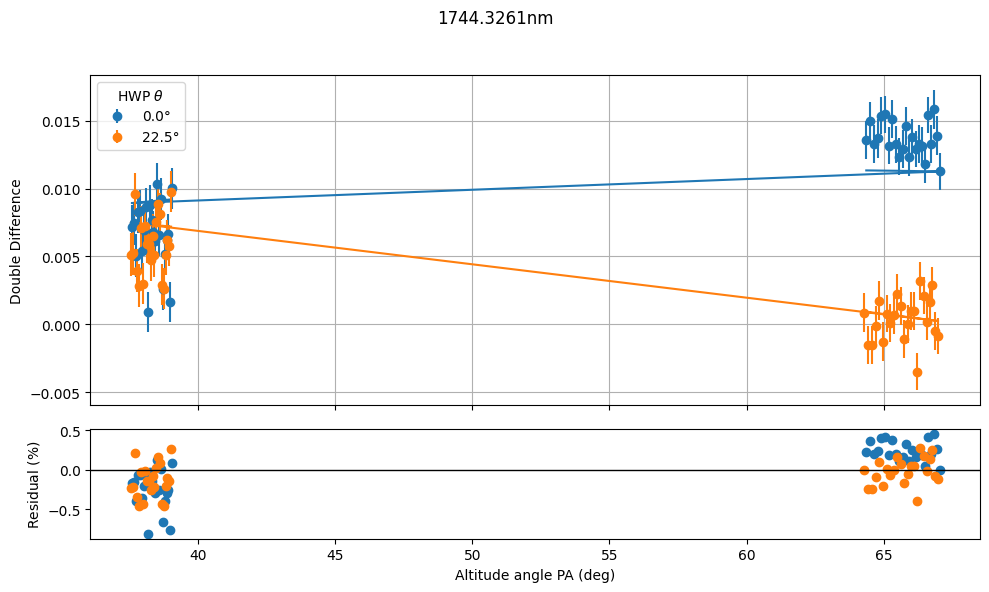

Updated Mueller Matrix:
[[ 0.49965469 -0.05882317  0.46961621 -0.14445051]
 [-0.49483818  0.05928199 -0.47420063  0.14585455]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
360 180
Residuals range: -0.8126045712279625 0.4566770283945638
Error: [2.87069038e-04 7.03005275e-01]
s_res: 0.26732113800367074
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.8726e+03                                    3.15e+05    
       1              2         1.9308e+03      1.94e+03       8.95e-03       1.23e+05    
       2              3         1.5812e+03      3.50e+02       2.25e-01       7.38e+03    
       3              4         1.5620e+03      1.93e+01       4.76e-01       7.23e+03    
       4              5         1.5228e+03      3.92e+01       9.52e-01       7.23e+03    
       5              6         1.4430e+03      7.98e+01       1.90e+00       1.26e+04    
    

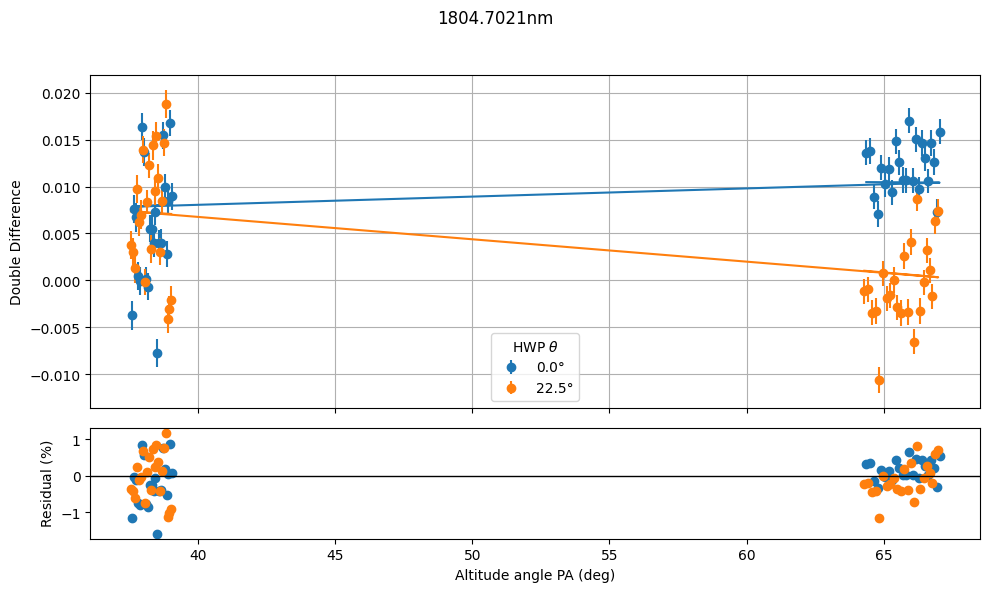

Updated Mueller Matrix:
[[ 0.49958652 -0.06342353  0.47047968 -0.13649382]
 [-0.49396718  0.06402259 -0.47584767  0.13804395]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
360 180
Residuals range: -1.5804639075194165 1.1691657780773963
Error: [5.7168538e-04 1.5120593e+00]
s_res: 0.5377776080838574
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         9.1337e+03                                    3.61e+05    
       1              2         6.8242e+03      2.31e+03       8.70e-03       1.75e+05    
       2              3         6.1149e+03      7.09e+02       2.04e-01       1.52e+04    
       3              4         6.0761e+03      3.88e+01       4.63e-01       1.50e+04    
       4              5         5.9972e+03      7.89e+01       9.25e-01       1.50e+04    
       5              6         5.8362e+03      1.61e+02       1.85e+00       1.78e+04    
       

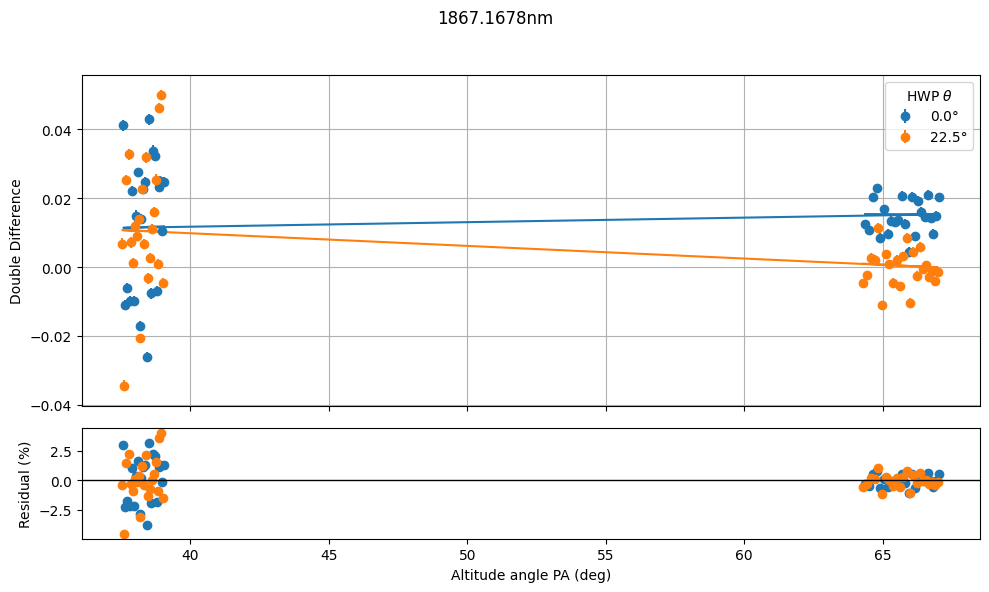

Updated Mueller Matrix:
[[ 0.49962516 -0.07365371  0.47228662 -0.12458483]
 [-0.49396302  0.07431788 -0.47772587  0.12601073]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
360 180
Residuals range: -4.522648323332769 3.965235075953408
Error: [1.46377017e-03 2.64893983e+00]
s_res: 1.4284118855494885
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.3646e+03                                    3.10e+05    
       1              2         1.5510e+03      1.81e+03       8.45e-03       1.24e+05    
       2              3         1.2070e+03      3.44e+02       2.12e-01       6.75e+03    
       3              4         1.1903e+03      1.67e+01       4.50e-01       6.62e+03    
       4              5         1.1565e+03      3.38e+01       8.99e-01       6.60e+03    
       5              6         1.0881e+03      6.84e+01       1.79e+00       1.12e+04    
       

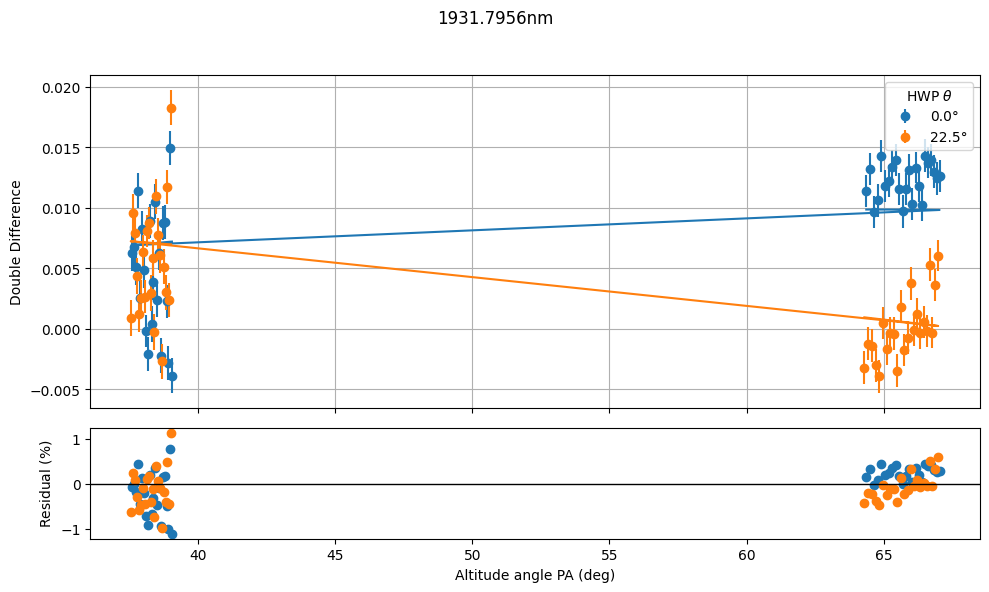

Updated Mueller Matrix:
[[ 0.49958271 -0.07589517  0.47413456 -0.11378958]
 [-0.49346844  0.07671137 -0.48002839  0.11519709]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
360 180
Residuals range: -1.107899772925149 1.1305311735813715
Error: [4.46299368e-04 1.25798780e+00]
s_res: 0.4198111188571575
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.6791e+03                                    3.38e+05    
       1              2         1.7151e+03      1.96e+03       8.21e-03       1.45e+05    
       2              3         1.2742e+03      4.41e+02       2.02e-01       8.72e+03    
       3              4         1.2532e+03      2.10e+01       4.38e-01       8.57e+03    
       4              5         1.2107e+03      4.25e+01       8.74e-01       8.54e+03    
       5              6         1.1247e+03      8.61e+01       1.74e+00       1.28e+04    
      

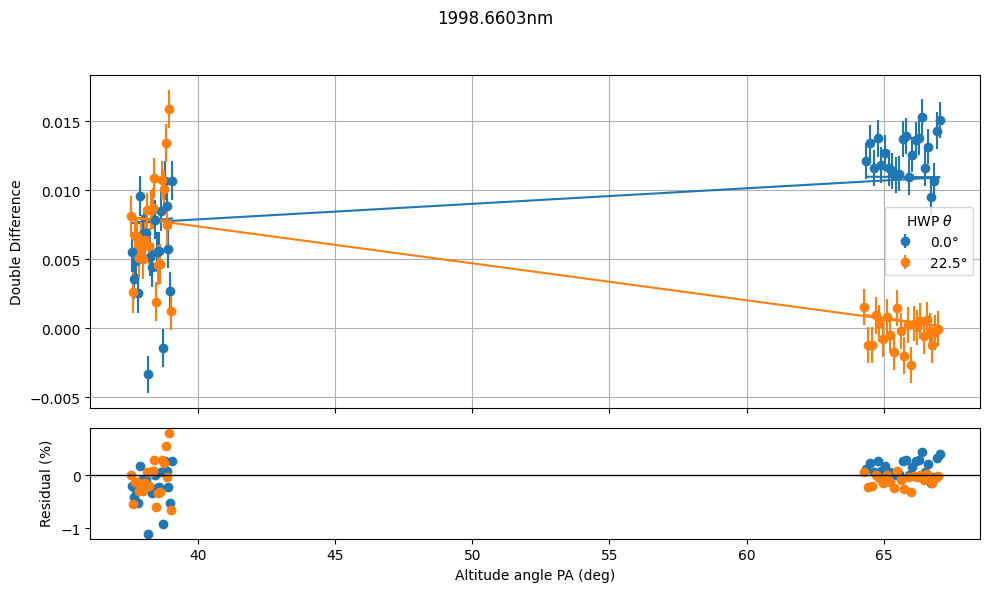

Updated Mueller Matrix:
[[ 0.49956043 -0.07624599  0.4773533  -0.10488384]
 [-0.49465101  0.07689255 -0.48210773  0.10592296]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
360 180
Residuals range: -1.1074753199767202 0.8102988889397624
Error: [3.13181027e-04 7.97196726e-01]
s_res: 0.29706901403166164
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.4721e+03                                    3.33e+05    
       1              2         1.6017e+03      1.87e+03       7.98e-03       1.40e+05    
       2              3         1.1997e+03      4.02e+02       1.98e-01       8.23e+03    
       3              4         1.1805e+03      1.92e+01       4.25e-01       8.09e+03    
       4              5         1.1415e+03      3.90e+01       8.50e-01       8.08e+03    
       5              6         1.0622e+03      7.93e+01       1.70e+00       1.25e+04    
    

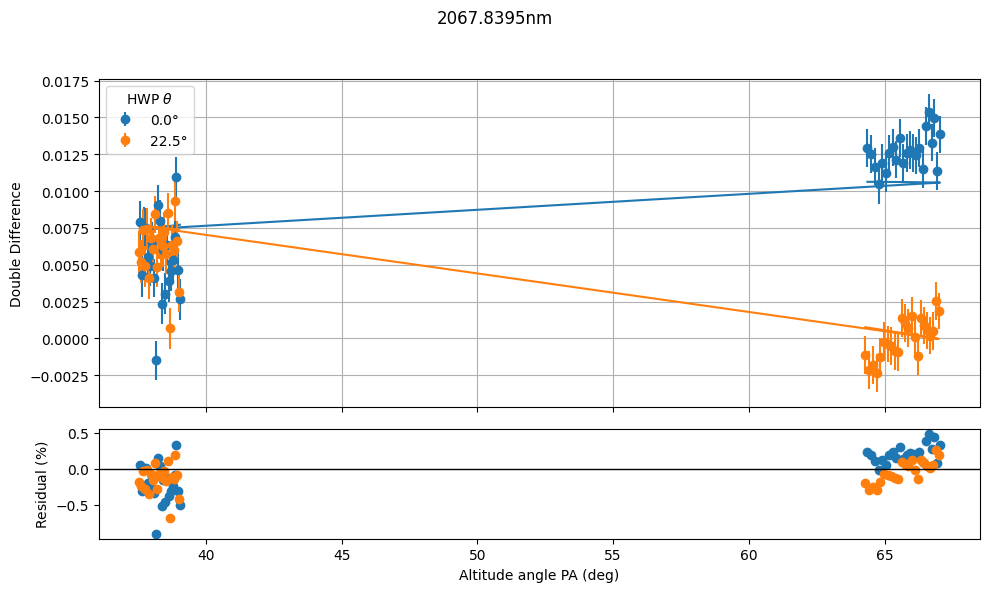

Updated Mueller Matrix:
[[ 0.49964536 -0.0754836   0.47799229 -0.09450241]
 [-0.49305611  0.07634875 -0.48440161  0.09576352]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
360 180
Residuals range: -0.8996780208721907 0.4787319391261111
Error: [2.67694759e-04 7.01946914e-01]
s_res: 0.24965159290851682
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.1674e+03                                    3.24e+05    
       1              2         1.4273e+03      1.74e+03       7.76e-03       1.29e+05    
       2              3         1.1019e+03      3.25e+02       1.95e-01       6.96e+03    
       3              4         1.0861e+03      1.58e+01       4.14e-01       6.84e+03    
       4              5         1.0541e+03      3.21e+01       8.26e-01       6.84e+03    
       5              6         9.8861e+02      6.54e+01       1.65e+00       1.17e+04    
    

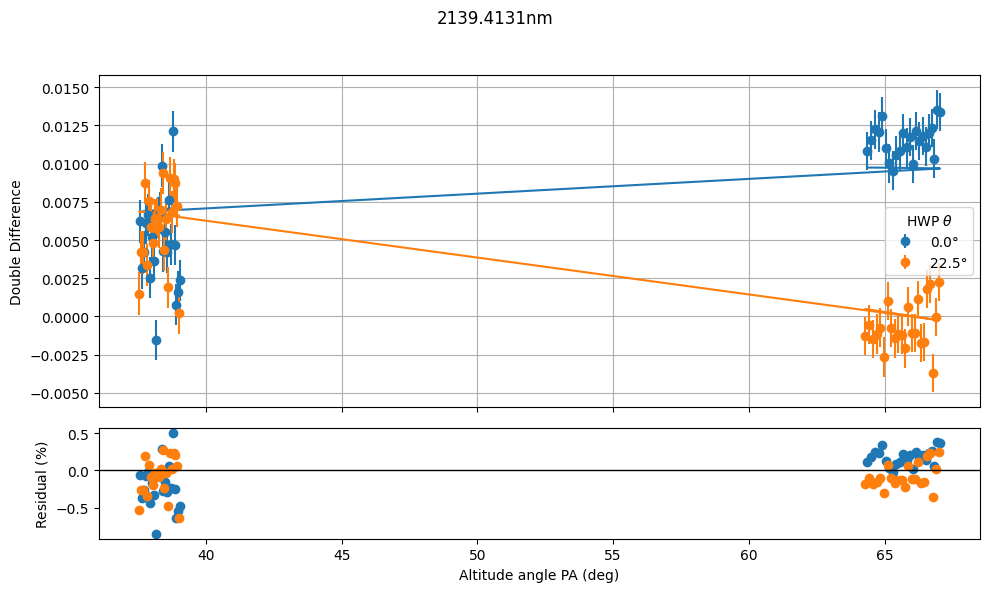

Updated Mueller Matrix:
[[ 0.49975952 -0.07354412  0.48078954 -0.08367684]
 [-0.4935266   0.07434868 -0.48687947  0.08473258]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
360 180
Residuals range: -0.8479968264842089 0.5027244834211076
Error: [2.80037166e-04 8.02243037e-01]
s_res: 0.2628291718254667
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.5744e+03                                    3.43e+05    
       1              2         1.7480e+03      1.83e+03       7.54e-03       1.46e+05    
       2              3         1.3461e+03      4.02e+02       1.86e-01       8.43e+03    
       3              4         1.3275e+03      1.86e+01       4.02e-01       8.30e+03    
       4              5         1.2897e+03      3.78e+01       8.03e-01       8.30e+03    
       5              6         1.2127e+03      7.70e+01       1.60e+00       1.27e+04    
     

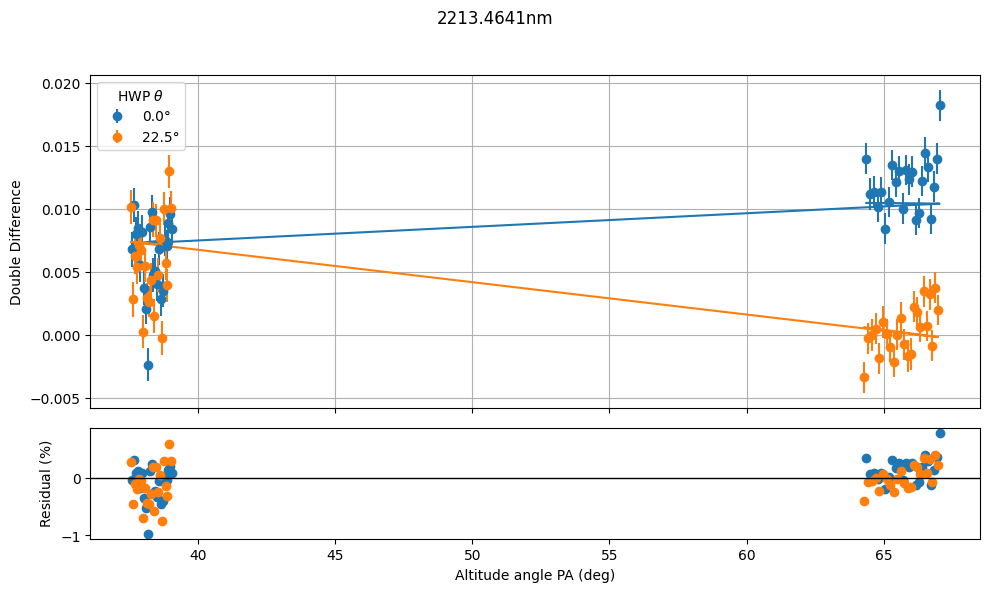

Updated Mueller Matrix:
[[ 0.4996734  -0.07168548  0.48002023 -0.07137626]
 [-0.49056268  0.07282023 -0.48896255  0.07270008]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
360 180
Residuals range: -0.9712783345115 0.779267941899757
Error: [3.21478427e-04 8.50520871e-01]
s_res: 0.2972118503260924
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.4024e+03                                    3.03e+05    
       1              2         1.8944e+03      1.51e+03       7.34e-03       1.12e+05    
       2              3         1.6582e+03      2.36e+02       1.87e-01       6.40e+03    
       3              4         1.6445e+03      1.37e+01       3.91e-01       6.29e+03    
       4              5         1.6164e+03      2.81e+01       7.80e-01       6.35e+03    
       5              6         1.5581e+03      5.83e+01       1.56e+00       1.23e+04    
       6 

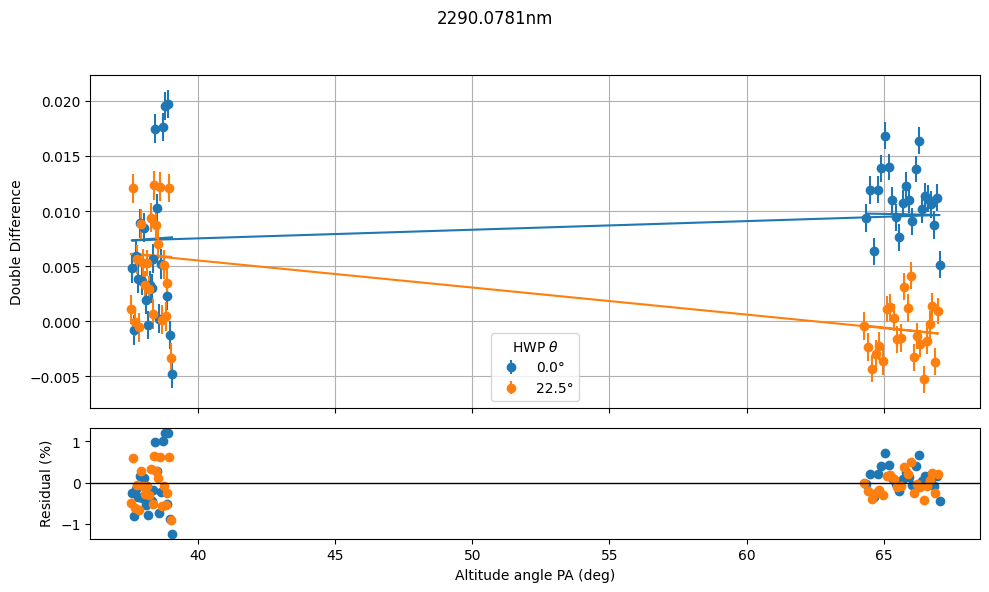

Updated Mueller Matrix:
[[ 0.50014474 -0.0641783   0.47980183 -0.0570478 ]
 [-0.48742364  0.06559348 -0.49235588  0.05853756]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
360 180
Residuals range: -1.2385977225953382 1.21015271844979
Error: [5.00781283e-04 1.40596703e+00]
s_res: 0.46308299039797896
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.7175e+03                                    2.78e+05    
       1              2         3.4457e+03      1.27e+03       7.14e-03       8.27e+04    
       2              3         3.3242e+03      1.22e+02       1.85e-01       4.04e+03    
       3              4         3.3158e+03      8.40e+00       3.80e-01       3.95e+03    
       4              5         3.2985e+03      1.73e+01       7.59e-01       5.54e+03    
       5              6         3.2620e+03      3.65e+01       1.51e+00       1.09e+04    
      

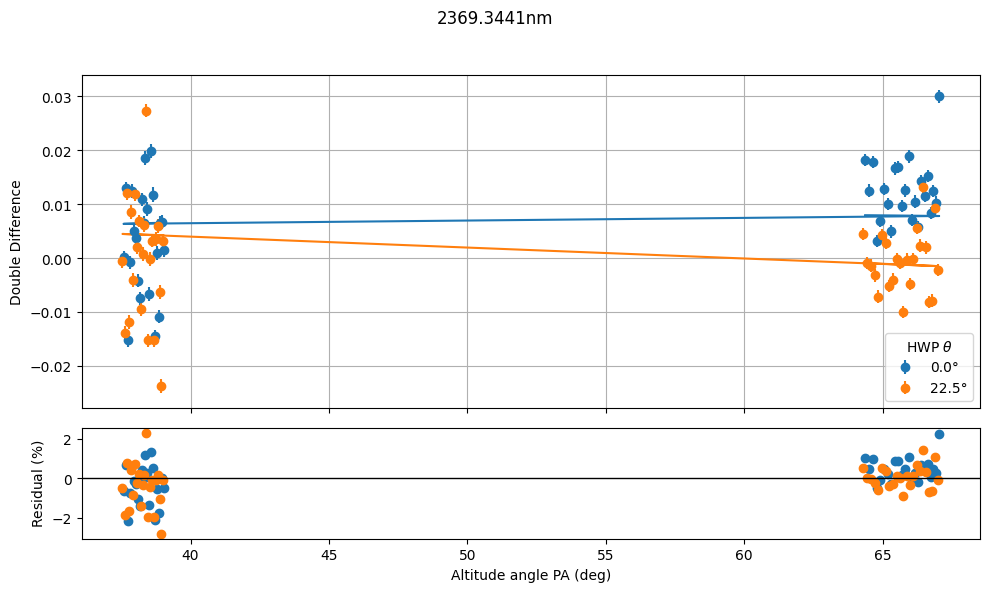

Updated Mueller Matrix:
[[ 0.5004069  -0.0606136   0.47095378 -0.04044024]
 [-0.47655557  0.06323663 -0.49457356  0.0424678 ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
360 180
Residuals range: -2.7947040641564698 2.3003533010648045
Error: [1.02238437e-03 3.41518230e+00]
s_res: 0.923445294563017


In [1]:
from pyPolCal.on_sky import fit_CHARIS_Mueller_matrix_by_bin_m3
errs = []
sres = []
for bin in range(22):
    fname = f'../datacsvs/onsky_nbs/HD10166_and_HD293396/bin{bin}.csv'
    sys_dict = f'../system_dictionaries/nbs_in_onsky/bin{bin}.json'
    err,fig, ax, sr = fit_CHARIS_Mueller_matrix_by_bin_m3(fname,bin,sys_dict)
    errs.append(err)
    sres.append(sr)

In [2]:
from pyPolCal.csv_tools import model_data
from pathlib import Path
jsondir = Path('/home/thomasmc/pyPolCal/pyPolCal/CHARIS/system_dictionaries/nbs_in_onsky')
df = model_data(jsondir)
df

,wavelength_bin,M3_delta_theta,M3_epsilon
0,1159.5614,-27.143774,-0.014478
1,1199.6971,-27.251356,-0.014817
2,1241.2219,-27.814325,-0.014270
3,1284.1840,-28.025768,-0.014210
4,1328.6331,-28.518398,-0.014118
5,1374.6208,-26.710143,-0.013674
6,1422.2002,-28.981855,-0.012810
7,1471.4264,-29.893796,-0.012782
8,1522.3565,-28.345822,-0.012367
9,1575.0495,-29.947455,-0.012822


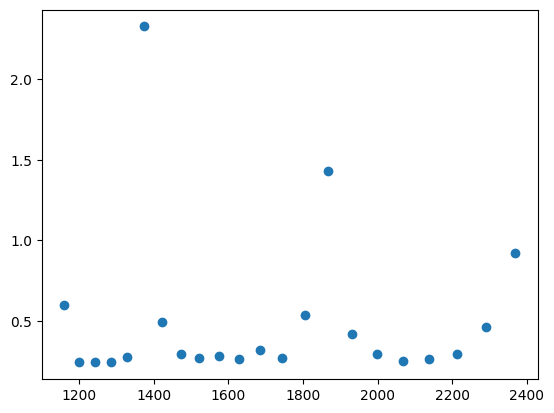

In [4]:
import matplotlib.pyplot as plt
from pyPolCal.constants import wavelength_bins
plt.scatter(wavelength_bins, sres)

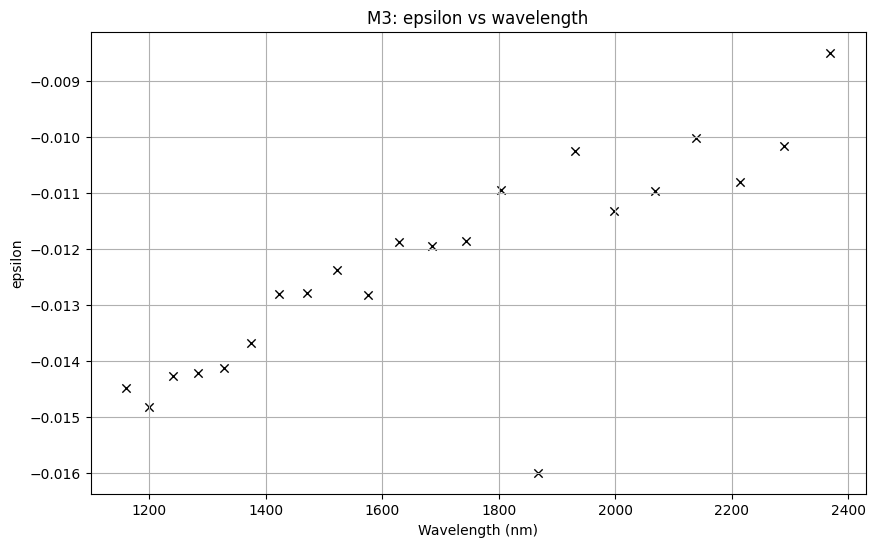

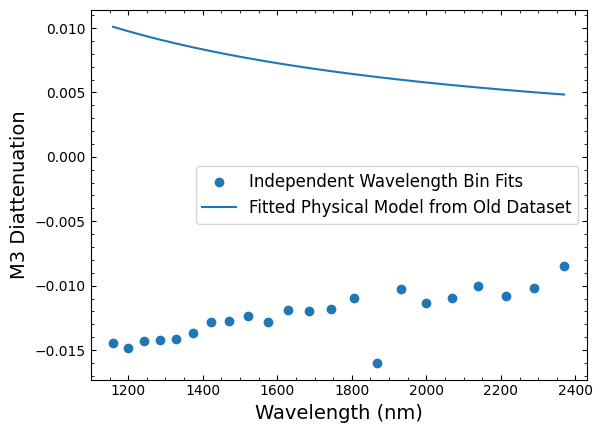

In [5]:
from pyPolCal.plotting import plot_config_dict_vs_wavelength
from pyMuellerMat.physical_models.charis_physical_models import *
params, fig, ax = plot_config_dict_vs_wavelength('M3','epsilon',jsondir)
fig2, ax2 = plt.subplots()
ax2.scatter(wavelength_bins,params, label='Independent Wavelength Bin Fits')
ax2.plot(wavelength_bins, M3_diattenuation(wavelength_bins), label='Fitted Physical Model from Old Dataset')
ax2.legend(fontsize=12)
ax2.set_xlabel('Wavelength (nm)', fontsize=14)
ax2.set_ylabel('M3 Diattenuation', fontsize=14)
ax2.tick_params(
    axis='x',
    direction='in',
    top=True,
    which='both',  
)
ax2.tick_params(
    axis='y',
    direction='in',
    right=True,
    which='both',
)
ax2.minorticks_on()


In [2]:
# global minimize
interleaved_values_glob, interleaved_stds_glob, configuration_list_glob = read_csv_physical_model_all_bins('../datacsvs/onsky_nbs/HD10166_and_HD293396/',m3=True)

wavelength_bin = 10
# Loading in past fits 
offset_imr = 0.00637# derotator offset
offset_hwp = -0.03303# HWP offset
offset_cal = -0.01506 # calibration polarizer offset
imr_theta = 0 # placeholder 
hwp_theta = 0 # placeholder
imr_phi = IMR_retardance(wavelength_bins,259.12694)[wavelength_bin]
hwp_phi = HWP_retardance(wavelength_bins,1.636,1.278)[wavelength_bin]
epsilon_cal = 1
m1, b1, m2, b2 = (1.94073,13.69728,2.07958,13.88817) # from MCMC
m3_diat = M3_diattenuation(wavelength_bins[wavelength_bin],m1,b1,m2,b2)
m3_ret = M3_retardance(wavelength_bins[wavelength_bin],m1,b1,m2,b2)

# Define instrument configuration as system dictionary
# Wollaston beam, imr theta/phi, and hwp theta/phi will all be updated within functions, so don't worry about their values here
system_dict = {
    "components" : {
        "wollaston" : {
        "type" : "CHARIS_wollaston_function",
        "properties" : {"wavelength": wavelength_bins[wavelength_bin], "beam": 'o'}, 
        "tag": "internal",
        },
        "image_rotator" : {
            "type" : "elliptical_IMR_function",
            "properties" : {"wavelength": wavelength_bins[wavelength_bin], "theta": imr_theta, "delta_theta": offset_imr},
            "tag": "internal",
        },
        "hwp" : {
            "type" : "two_layer_HWP_function",
            "properties" : {"wavelength":wavelength_bins[wavelength_bin], "w_SiO2":1.636, "w_MgF2":1.278,"theta": hwp_theta, "delta_theta": offset_hwp},
            "tag": "internal",
        },
        "altitude_rot" : {
            "type" : "rotator_function",
            "properties" : {"pa":0},
            "tag":"internal",
        },
        "M3" : {
            "type" : "SUBARU_M3_function",
            "properties" : {"m1":m1, "m2":m2, "b1":b1, "b2":b2},
            "tag": "internal",
        },

        "parang_rot" : {
            "type" : "rotator_function",
            "properties" : {"pa":0},
            "tag":"internal",
        },
}}

# Converting system dictionary into system Mueller Matrix object
system_mm = generate_system_mueller_matrix(system_dict)

# Define initial guesses for our parameters 

# MODIFY THIS IF YOU WANT TO CHANGE PARAMETERS
p0_dict = {
    "M3": {
        "m1": m1,
        "m2": m2,
        "b1": b1,
        "b2": b2,
        "delta_theta":0
}}

m1_bounds = (0.7*m1, 1.3*m1)
m2_bounds = (0.7*m2, 1.3*m2)
b1_bounds = (0.7*b1, 1.3*b1)
b2_bounds = (0.7*b2, 1.3*b2)
bounds = [m1_bounds, m2_bounds, b1_bounds, b2_bounds,(-50,50)]


In [3]:
from pyPolCal.fitting import minimize_system_mueller_matrix
result_min, logl_min=minimize_system_mueller_matrix(p0_dict,system_mm,interleaved_values_glob,
                               configuration_list_glob,interleaved_stds_glob,s_in=[1,0,0,0],process_dataset=process_dataset,
                               process_errors=process_errors, process_model=process_model,include_sums=False,
                               bounds=bounds,mode='minimize')
print(result_min)

KeyboardInterrupt: 

In [13]:
def calc_s_res_global(csvdir, system_dict,p0_dict, number_of_fitted_params, m3=False):
    """
    Calculate s_res as in VLT SPHERE 2019 polcal appendix E for all CHARIS
    wavelength bins. All system dict mueller matrices must be a function of wavelength
    except for what is in the configuration list.

    Parameters
    -----------
    csvdir : str
        Path to the directory containing the CSV files.
    system_dict : dict
        Dictionary containing system parameters.
    p0_dict : dict
        Dictionary containing initial guess parameters.
    number_of_fitted_params : int
        Number of parameters fitted using the data in <csvdir>.
    m3 : bool, optional
        Whether or not m3 is in the system dictionary. Default is False.

    Returns
    --------
    list
        A list of s_res values for each wavelength bin.

    """

    # generate system mueller matrix
    system_mm_ = generate_system_mueller_matrix(system_dict)

    # read csv into single differences and parse configuration list
    interleaved_values, interleaved_stds, configuration_list = read_csv_physical_model_all_bins(csvdir, m3=m3)
    p0_values, p0_keywords = parse_configuration(p0_dict)

    # update system mm with p0 
    system_mm = update_system_mm(p0_values,p0_keywords,system_mm_)

    # generate simulated normalized single differences
    LR_intensities = model(p0_values, p0_keywords, system_mm, configuration_list)

    # process into modeled double differences
    modeled_diffs = process_model(LR_intensities)[::2]

    # process observed data into double differences
    obs_diff = process_dataset(interleaved_values)[::2]

    # convert units to percent and calculate residuals
    residuals = obs_diff*100 - modeled_diffs*100

    # group by wavelength bin using a bin mask
    s_res_by_wavelength = []
    for bin in range(22):
        # mask per bin
        bin_mask = []
        for dict in configuration_list[::2]:
            if dict['hwp']['wavelength'] == wavelength_bins[bin]:
                bin_mask.append(True)
            else:
                bin_mask.append(False)
        # apply mask
        double_diffs_by_bin = obs_diff[bin_mask]
        modeled_diffs_by_bin = modeled_diffs[bin_mask]
        residuals_by_bin = double_diffs_by_bin*100-modeled_diffs_by_bin*100
        # calculate s_res
        s_res = np.sqrt(np.sum(residuals_by_bin**2)/(len(double_diffs_by_bin)-number_of_fitted_params))
        s_res_by_wavelength.append(s_res)

    return s_res_by_wavelength




In [14]:

system_dict = {
    "components" : {
        "wollaston" : {
        "type" : "CHARIS_wollaston_function",
        "properties" : {"wavelength": 500, "beam": 'o'}, 
        "tag": "internal",
        },
        "image_rotator" : {
            "type" : "elliptical_IMR_function",
            "properties" : {"wavelength": 1000, "theta": 0, "delta_theta": offset_imr},
            "tag": "internal",
        },
        "hwp" : {
            "type" : "two_layer_HWP_function",
            "properties" : {"wavelength":1000, "w_SiO2":1.636, "w_MgF2":1.278,"theta": 0, "delta_theta": offset_hwp},
            "tag": "internal",
        },
        "altitude_rot" : {
            "type" : "rotator_function",
            "properties" : {"pa":0},
            "tag":"internal",
        },
        "M3" : {
            "type" : "SUBARU_naive_M3_function",
            "properties" : {"wavelength":1000},
            "tag": "internal",
        },

        "parang_rot" : {        
            "type" : "rotator_function",
            "properties" : {"pa":0},
            "tag":"internal",
        },
}}

p0_dict = {
    'hwp': {
        'delta_theta': offset_hwp}
    }
csvdir = Path('../datacsvs/onsky_nbs/HD10166_and_HD293396/')
s_res = calc_s_res_global(csvdir, system_dict, p0_dict, number_of_fitted_params=2, m3=True)

[np.float64(0.597736590053061), np.float64(0.23709915055972305), np.float64(0.238095964717317), np.float64(0.24582836453342388), np.float64(0.2776658702874877), np.float64(2.328402138043983), np.float64(0.4939130499779588), np.float64(0.29730038161984546), np.float64(0.2746867644495379), np.float64(0.2854677148941132), np.float64(0.2642402820638283), np.float64(0.31869858947796303), np.float64(0.2689878381213495), np.float64(0.5380962952757418), np.float64(1.4282588720184026), np.float64(0.4206309181528906), np.float64(0.2976496912880796), np.float64(0.25000626435884943), np.float64(0.26261991593643447), np.float64(0.29650526210231076), np.float64(0.46243062622081776), np.float64(0.9219419862497628)]


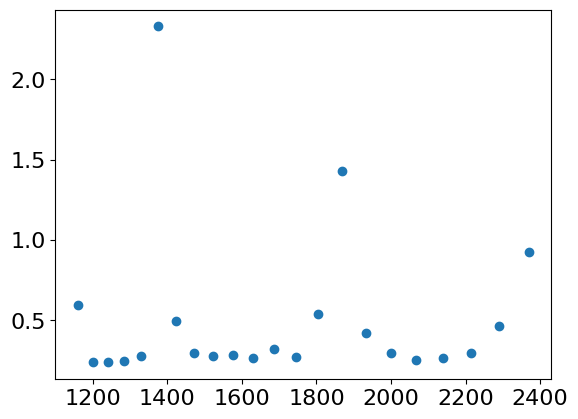

In [ ]:
plt.scatter(wavelength_bins,s_res)